In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import simtk.openmm as mm
from torsionfit import TorsionScanSet as ScanSet
import torsionfit.TorsionFitModel as Model
from torsionfit import sqlite_plus
from pymc import MCMC
from parmed.charmm import CharmmParameterSet
from torsionfit import plots
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
param_to_opt=[('CG331', 'CG321', 'CG321', 'CG331')]
param = CharmmParameterSet('../data/charmm_ff/top_all36_cgenff.rtf', '../data/charmm_ff/par_all36_cgenff.prm')
structure = 'structure/butane.psf'
scan = 'MP2_torsion_scan/'
# Print initial guess
print param.dihedral_types[param_to_opt[0]]


<DihedralTypes [<DihedralType; phi_k=0.038, per=2, phase=0.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=0.032, per=6, phase=180.000,  scee=1.000, scnb=1.000>]>


In [3]:
butane_scan = ScanSet.parse_psi4_out(scan, structure)
butane_scan.compute_energy(param)

[Psi /Users/sternc1/src/ChayaSt/Torsions/examples/butane/MP2_torsion_scan/0/butane_0.out2 WARNING] In logfileparser.py, line 468, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/Torsions/examples/butane/MP2_torsion_scan/10/butane_10.out2 WARNING] In logfileparser.py, line 468, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/Torsions/examples/butane/MP2_torsion_scan/20/butane_20.out2 WARNING] In logfileparser.py, line 468, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/Torsions/examples/butane/MP2_torsion_scan/30/butane_30.out2 WARNING] In logfileparser.py, line 468, line not all dashes as expected: ------------------------------------------------------

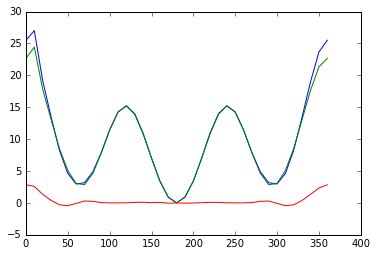

In [4]:
plt.plot(butane_scan.steps, butane_scan.qm_energy)
plt.plot(butane_scan.steps, butane_scan.mm_energy)
plt.plot(butane_scan.steps, butane_scan.delta_energy)

In [5]:
# Turn Torsion off and look at the difference potential
# Turn off torsion
param.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][1].phi_k=0
param.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][0].phi_k=0

In [6]:
butane_scan_0 = ScanSet.parse_psi4_out(scan, structure)
butane_scan_0.compute_energy(param)

[Psi /Users/sternc1/src/ChayaSt/Torsions/examples/butane/MP2_torsion_scan/0/butane_0.out2 WARNING] In logfileparser.py, line 468, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/Torsions/examples/butane/MP2_torsion_scan/10/butane_10.out2 WARNING] In logfileparser.py, line 468, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/Torsions/examples/butane/MP2_torsion_scan/20/butane_20.out2 WARNING] In logfileparser.py, line 468, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/Torsions/examples/butane/MP2_torsion_scan/30/butane_30.out2 WARNING] In logfileparser.py, line 468, line not all dashes as expected: ------------------------------------------------------

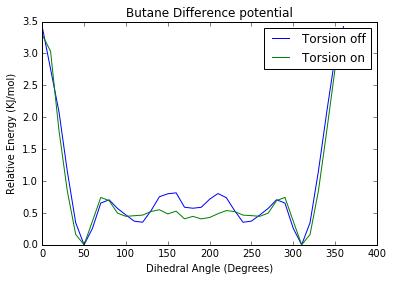

In [7]:
#plt.plot(butane_scan_0.mm_energy)
#plt.plot(butane_scan_0.qm_energy)
optimized_0 = butane_scan_0.remove_nonoptimized()
optimized_0.compute_energy(param)
plt.plot(optimized_0.steps, optimized_0.delta_energy-min(optimized_0.delta_energy), label='Torsion off')
plt.plot(butane_scan.steps, butane_scan.delta_energy-min(butane_scan.delta_energy), label='Torsion on')
plt.legend()
plt.xlabel('Dihedral Angle (Degrees)')
plt.ylabel('Relative Energy (KJ/mol)')
plt.title('Butane Difference potential')
plt.savefig('butane_diff_pot.png')

In [8]:
platform = mm.Platform.getPlatformByName('Reference')
model = Model.TorsionFitModelEliminatePhase(param, optimized_0, platform=platform, 
                                            param_to_opt=param_to_opt, sample_n5=True)
sampler = MCMC(model.pymc_parameters, db=sqlite_plus, dbname='butane_n5_init_0.db', verbose=5)

In [9]:
sampler.sample(10000)

Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_1_K
Assigning step method Metropolis to stochastic log_sigma
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_2_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_5_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_6_K
Assigning step method Metropolis to stochastic BUTA1_offset
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_3_K
Assigning step method DiscreteMetropolis to stochastic CG331_CG321_CG321_CG331_multiplicity_bitstring
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_4_K
 [-----------------100%-----------------] 10000 of 10000 complete in 530.1 sec

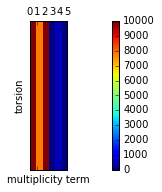

In [15]:
samples = 10000
burn = 0
multiplicities = (1,2,3,4,5,6)
import numpy as np
mult_bitstring = []
for i in model.pymc_parameters.keys():
    if i.split('_')[-1] == 'bitstring':
        mult_bitstring.append(i)

histogram = np.zeros((len(mult_bitstring), samples, 6))

for m, torsion in enumerate(mult_bitstring):
    for i, j in enumerate(sampler.trace('%s' % torsion)[burn:]):
        for k, l in enumerate(multiplicities):
            if 2**(l-1) & int(j):
                histogram[m][i][k] = 1

plt.matshow(histogram.sum(1), cmap='jet',  extent=[0, 5, 0, 20]), plt.colorbar()
plt.yticks([])
plt.xlabel('multiplicity term')
plt.ylabel('torsion')
#plt.savefig(filename)

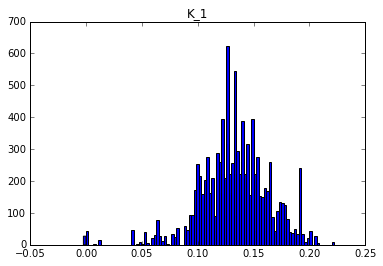

In [17]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_1_K')[:], bins=100)
plt.title('K_1')

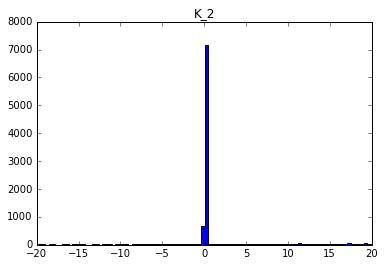

In [18]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_2_K')[:], bins=100)
plt.title('K_2')

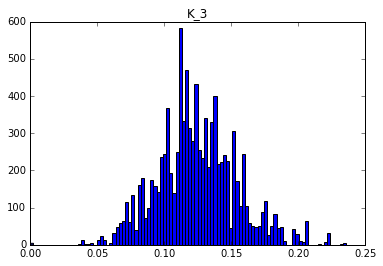

In [19]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_3_K')[:], bins=100)
plt.title('K_3')

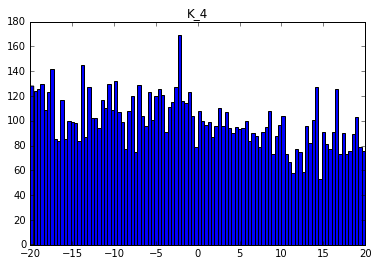

In [20]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_4_K')[:], bins=100)
plt.title('K_4')

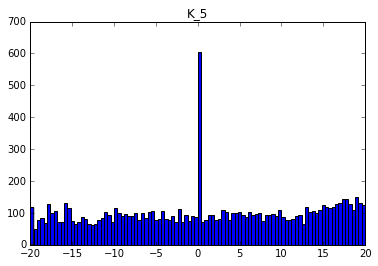

In [21]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_5_K')[:], bins=100)
plt.title('K_5')

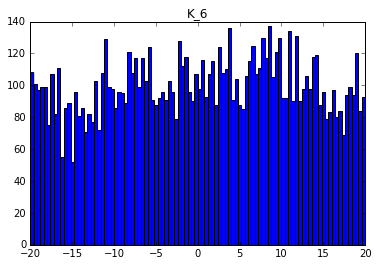

In [22]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_6_K')[:], bins=100)
plt.title('K_6')

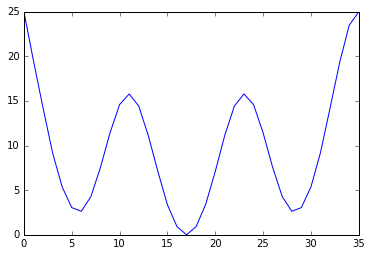

In [23]:
plt.plot(sampler.trace('mm_energy')[-1])

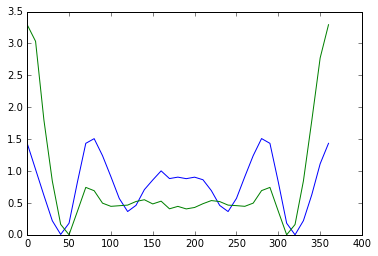

In [30]:
#plt.plot(sampler.trace('mm_energy')[-1])
#plt.plot(optimized_0.mm_energy)
plt.plot(optimized_0.steps, optimized_0.delta_energy - min(optimized_0.delta_energy))
plt.plot(butane_scan.steps, butane_scan.delta_energy - min(butane_scan.delta_energy))

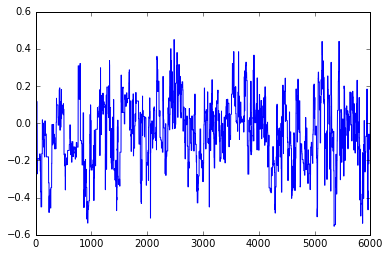

In [33]:
plt.plot(sampler.BUTA1_offset.trace[4000:])